# Hate Speech Detector 2.0
---
**Vectorizers quality analysis with application of Simple Machine Learning classifier** (part 1/2)

1. Load lemmatized tweets.
2. Select severe vectorizers to analysis.
3. Select the best Simple ML Classifier from the previous task (**SGD with l2 penalty**).
4. Perform multilabel classification task using different vectorizers.
5. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
6. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.vectorizers.CharacterVectorizer import CharacterVectorizer
from src.vectorizers.WordSimpleBoWVectorizer import WordSimpleBoWVectorizer
from src.vectorizers.WordPretrainedVectorizer import WordPretrainedVectorizer
from src.vectorizers.WordOwnTrainedVectorizer import WordOwnTrainedVectorizer

from src.classifiers.SimpleMLVectorClassifier import SimpleMLVectorClassifier
from src.dataframes.utils import classes, combine_row_wisely, shuffle_dataframe
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import (LABELS,
                           DUPLICATED_PATH, LEMMAS_PATH,
                           COMBINED_TESTONLY_PATH, LEMMAS_TESTONLY_PATH,
                           SMLCV_CHART_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
plt.style.use('ggplot')

## Data loading

### Classes

In [4]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


In [5]:
df_test_classes = pd.read_csv(COMBINED_TESTONLY_PATH)[LABELS]
df_test_classes = classes(df_test_classes, convert_null=True)
df_test_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [6]:
df_lemmatized = pd.read_csv(LEMMAS_PATH).drop(['id'], axis=1)
df_lemmatized.head(2)

,lemmatized
0,w czwartek musieć poprawić sąd i trybunał
1,żale nałęcz i riposta macierewicz pan być w ko...


In [7]:
df_test_lemmatized = pd.read_csv(LEMMAS_TESTONLY_PATH).drop(['id'], axis=1)
df_test_lemmatized.head(2)

,lemmatized
0,warto poznać śląsk i ślązak zanim zacząć się w...
1,jeszcze nie być całkiem bezkarny sąd jeszcze t...


### Combined data

In [8]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,lemmatized,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
10883,po co sąd i koszt zwykły wpierdol wystarczyć,0,0,0,0,0,0,0
1149,nie gdyż choroba mieć przerzut gdyby sąd dział...,0,0,0,0,0,0,0


In [9]:
df_test_data = combine_row_wisely([df_test_lemmatized, df_test_classes])
df_test_data.head(2)

,lemmatized,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,warto poznać śląsk i ślązak zanim zacząć się w...,0,0,0,0,0,0,0
1,jeszcze nie być całkiem bezkarny sąd jeszcze t...,0,0,0,0,0,0,0


## Models implementation and testing

In [10]:
VEC_CLASSES = [CharacterVectorizer, WordSimpleBoWVectorizer,
               WordPretrainedVectorizer, WordPretrainedVectorizer,
               WordOwnTrainedVectorizer, WordOwnTrainedVectorizer,
              ]
VEC_KWARGS = [{}, {},
              {'model_type': 'cbow', 'short_name': 'CBoW'}, {'model_type': 'skipg', 'short_name': 'SkipGram'},
              {'model_type': 'cbow', 'short_name': 'CBoW'}, {'model_type': 'skipg', 'short_name': 'SkipGram'},
             ]
VEC_LABELS = ['Chars', 'Simple-BoW',
              'W2V-pret-CBoW', 'W2V-pret-SkipGram',
              'W2V-mtr-CBoW', 'W2V-mtr-SkipGram',
             ]

In [11]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

X_test_data = df_test_data.drop(LABELS, axis=1).values
y_test_data = df_test_data[LABELS].values

y_preds = list([])

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/vectorizers/CharacterVectorizer.py:28: RuntimeWarning: Desired length of vector greater than vector length. Excessive text will be truncated!
  category=RuntimeWarning, stacklevel=1)


/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/vectorizers/CharacterVectorizer.py:28: RuntimeWarning: Desired length of vector greater than vector length. Excessive text will be truncated!
  category=RuntimeWarning, stacklevel=1)


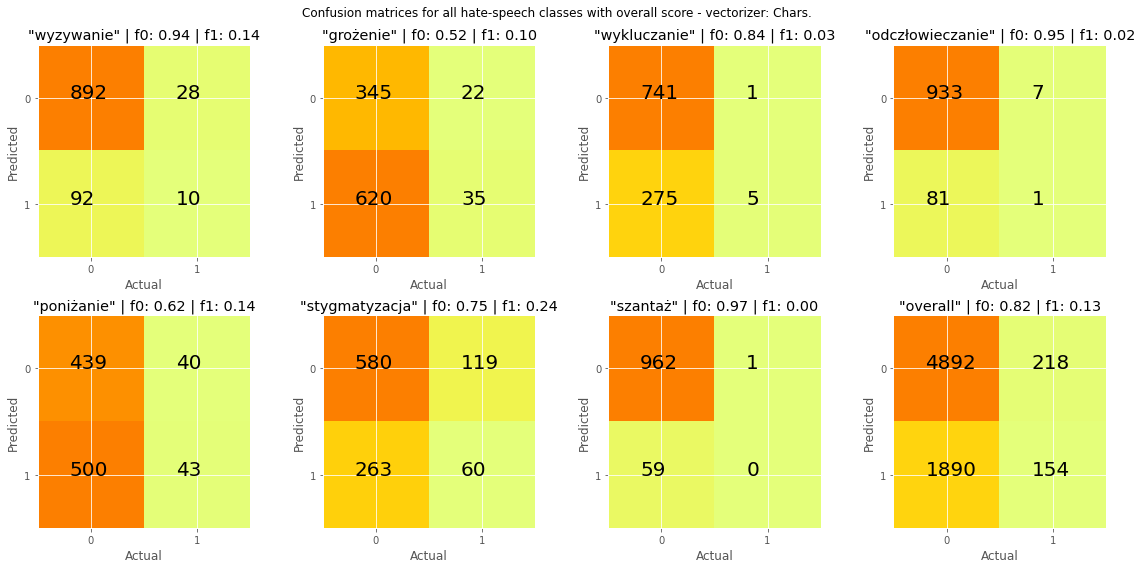

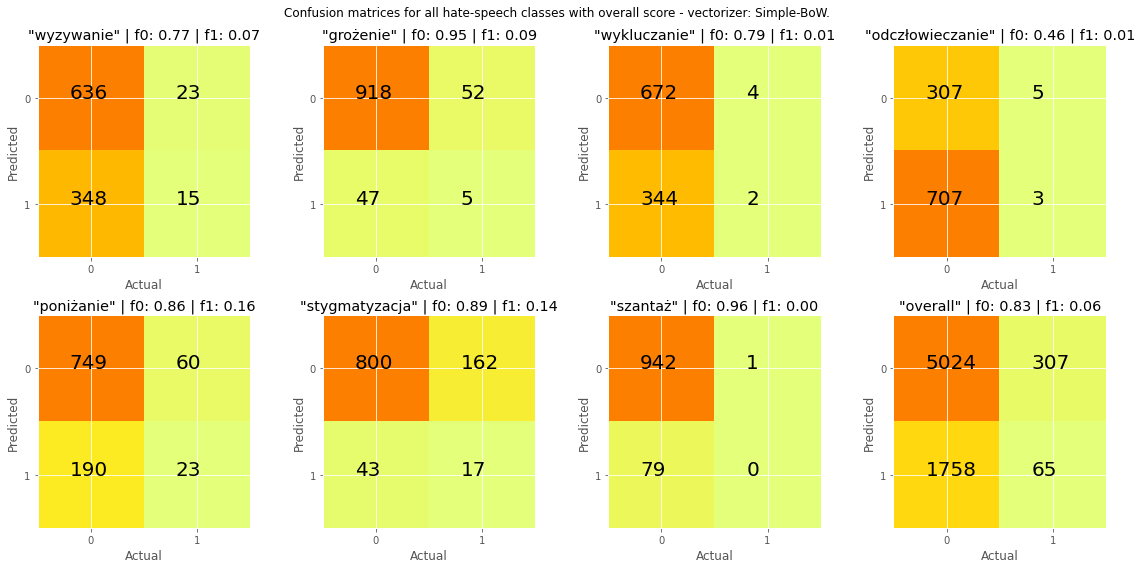

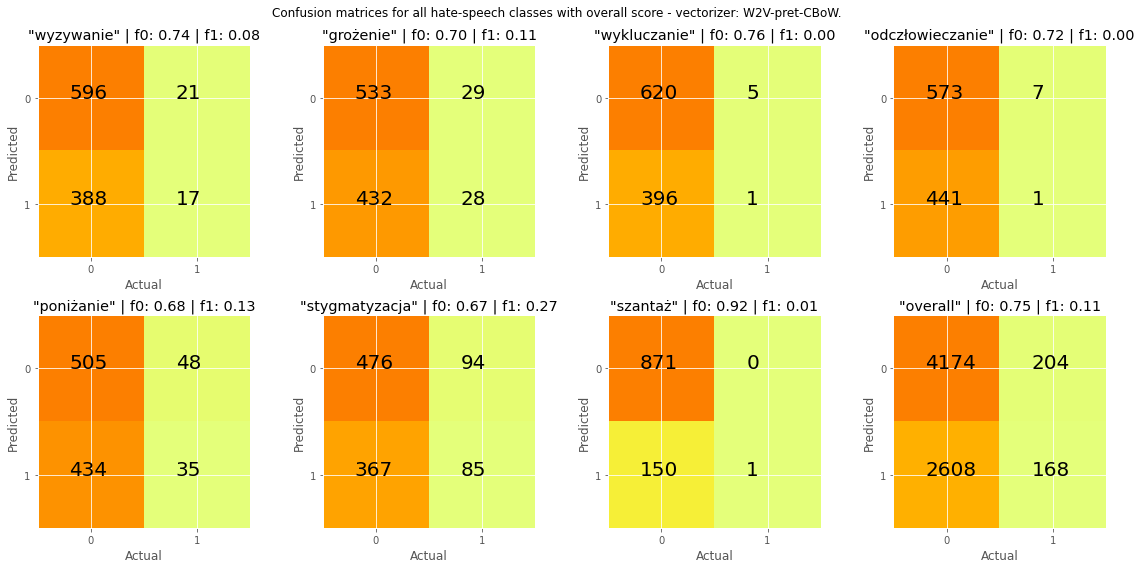

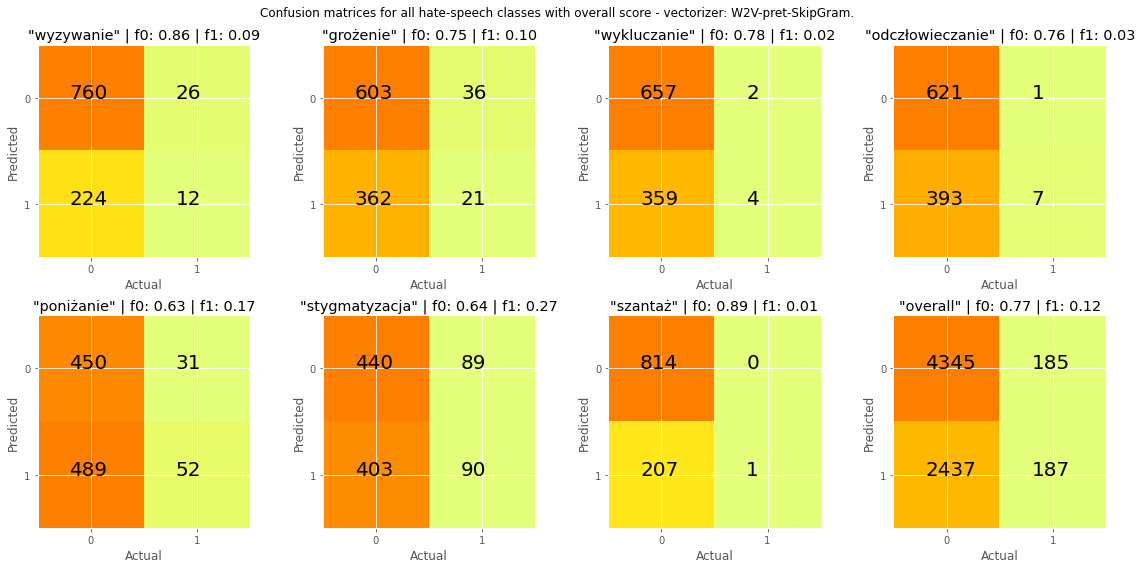

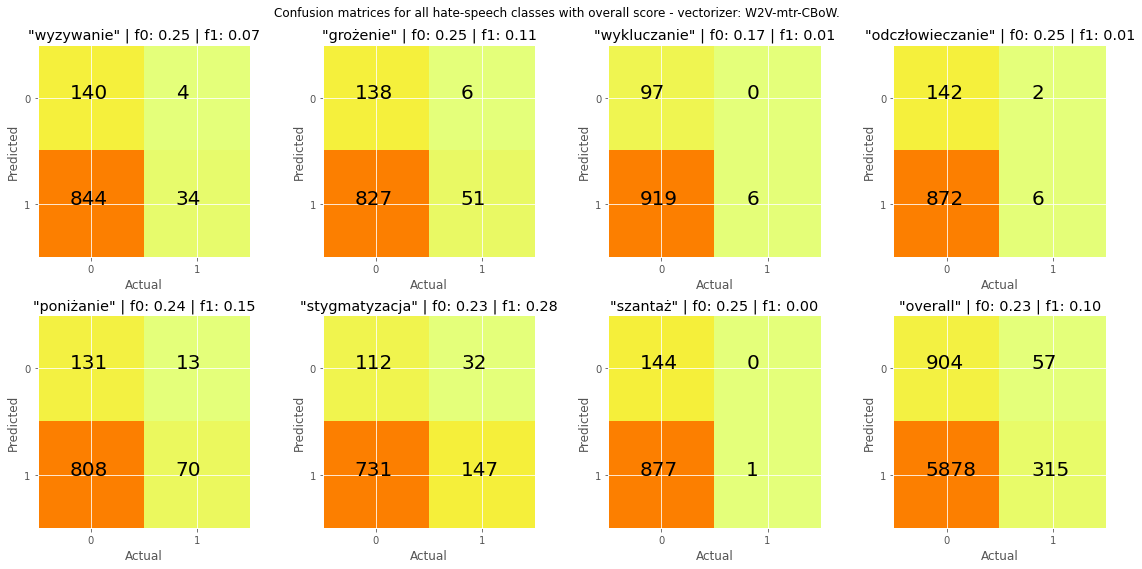

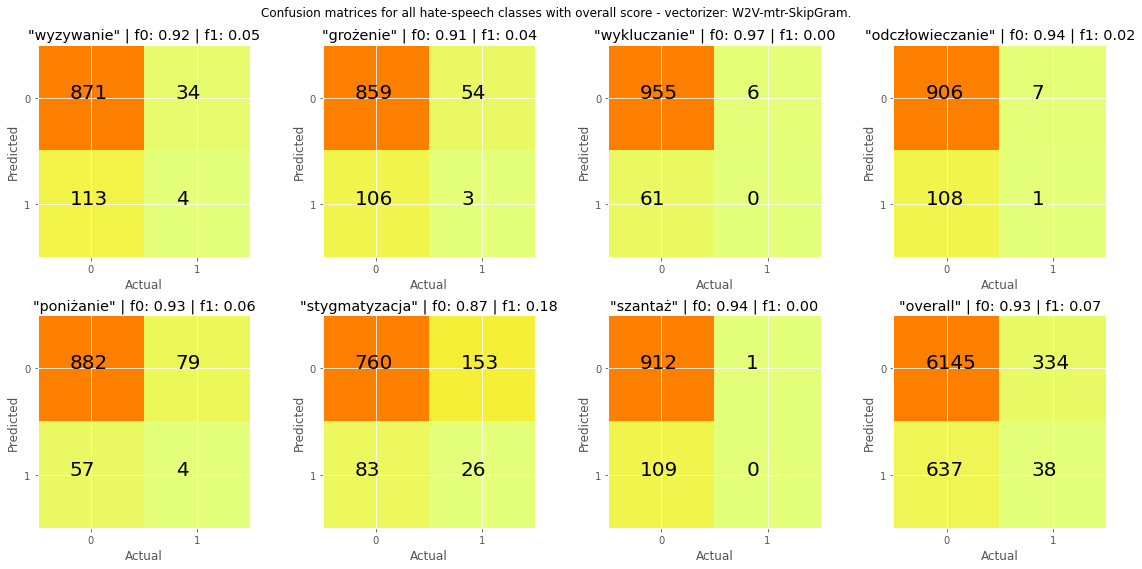

In [12]:
clf_kwargs = dict({'penalty': 'l2', 'class_weight': 'balanced'})
for vclass, vkwargs, vlabel in tqdm(zip(VEC_CLASSES, VEC_KWARGS, VEC_LABELS),
                                                   total=len(VEC_LABELS), leave=None):
    clf = SimpleMLVectorClassifier(k_folds=5, short_name=vlabel, vec_analysis=True,
                                   vec_class=vclass, clf_class=SGDClassifier,
                                   verbose=0, vec_kwargs=vkwargs, **clf_kwargs)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_test_data)
    confusion_matrices(y_test_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score - vectorizer: {vlabel}.',
                       save_file=SMLCV_CHART_DIR.replace('{}', f'confusion_matrices_{vlabel}'))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

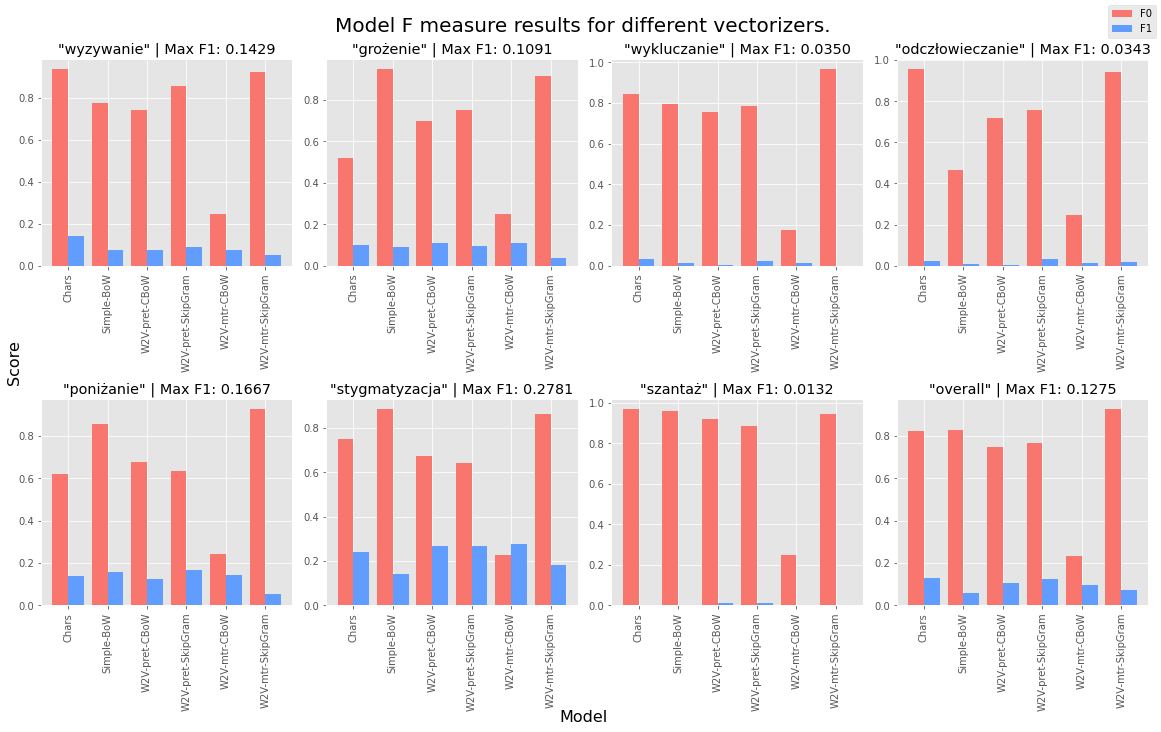

In [13]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='Model F measure results for different vectorizers.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=SMLCV_CHART_DIR.replace('{}', 'models_F_bars'))

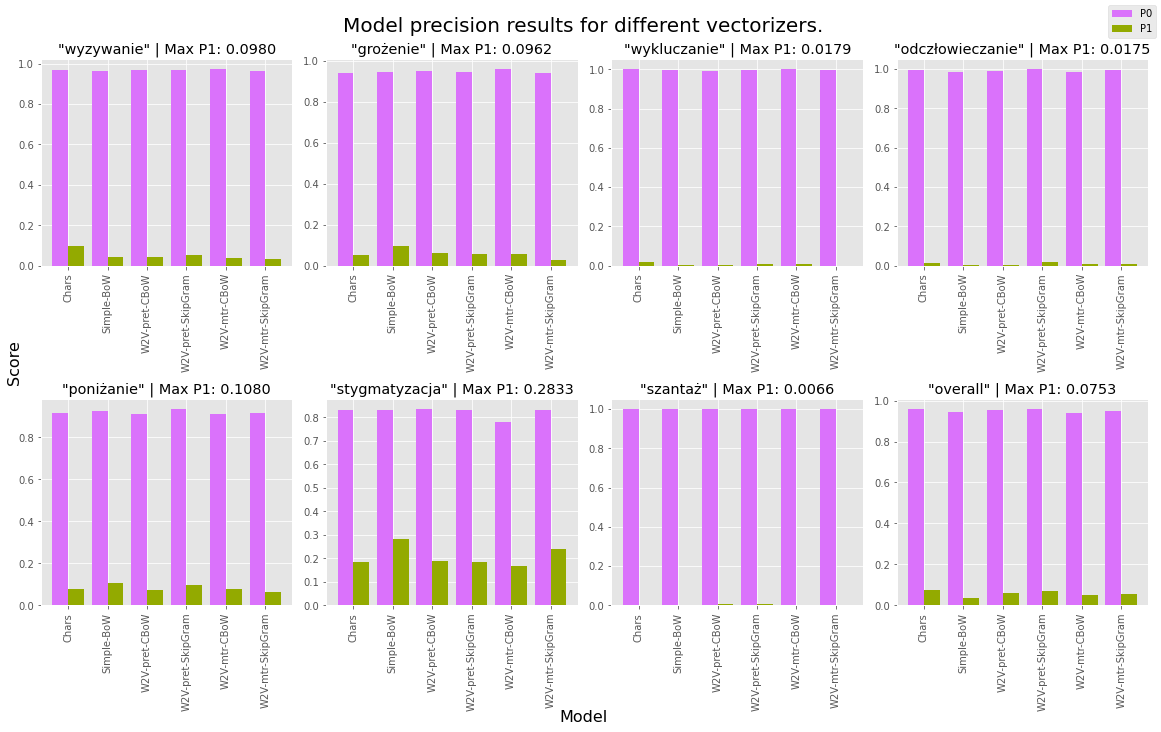

In [14]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='Model precision results for different vectorizers.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=SMLCV_CHART_DIR.replace('{}', 'models_P_bars'))

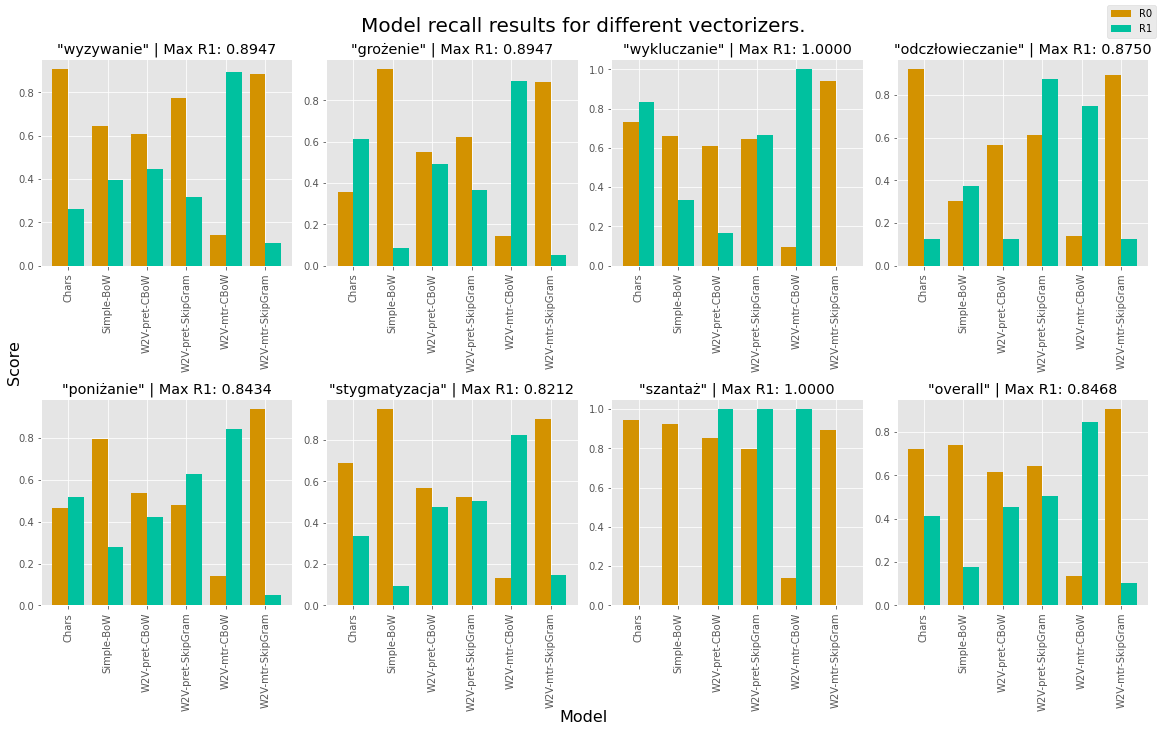

In [15]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                    title='Model recall results for different vectorizers.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=SMLCV_CHART_DIR.replace('{}', 'models_R_bars'))

## Best vectorizer

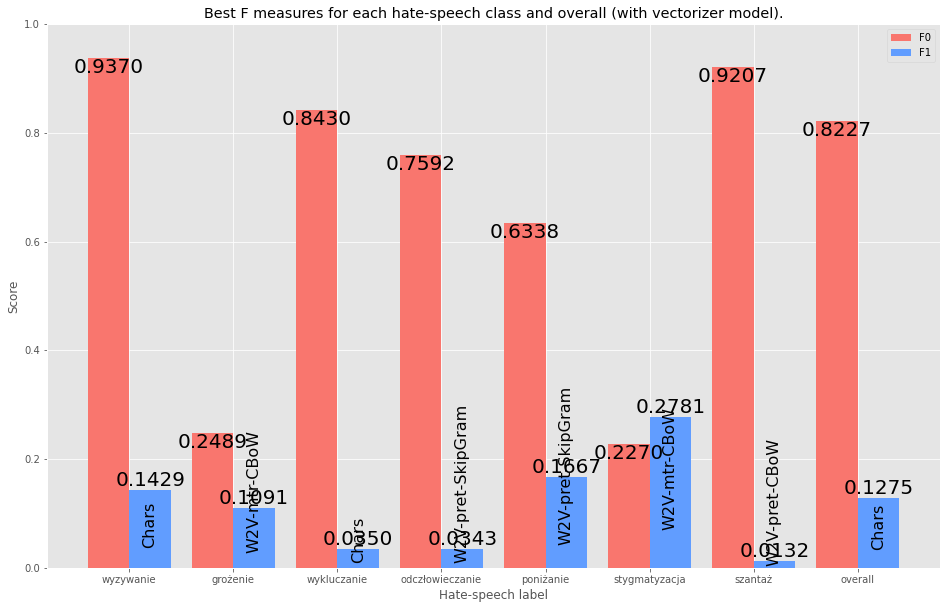

In [16]:
best_model_for_class(y_trues=y_test_data, y_preds_s=y_preds, model_names=VEC_LABELS,
                     title='Best F measures for each hate-speech class and overall (with vectorizer model).',
                     save_file=SMLCV_CHART_DIR.replace('{}', 'best_F_bars'))

Judging by the above two analyses the best vectorizer for classifier is **Pretrained Word2Vec SkipGram Vectorizer**.

In [19]:
vkwargs = dict({'model_type': 'skipg', 'short_name': 'SkipGram'})
clf_kwargs = dict({'penalty': 'l2', 'class_weight': 'balanced'})
clf = SimpleMLVectorClassifier(k_folds=5, short_name='W2V-pret-SkipGram', vec_analysis=True,
                               vec_class=WordPretrainedVectorizer, clf_class=SGDClassifier,
                               vec_kwargs=vkwargs, **clf_kwargs)
clf.load()

## Tests

### Test 1

In [20]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1.flatten()))

{'wyzywanie': 0,
 'grożenie': 1,
 'wykluczanie': 0,
 'odczłowieczanie': 1,
 'poniżanie': 0,
 'stygmatyzacja': 1,
 'szantaż': 0}

Empirically should be 'stygmatyzacja' and 'poniżanie' as positive. (**4/7 correct**) but no positive!

### Test 2

In [21]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2.flatten()))

{'wyzywanie': 1,
 'grożenie': 1,
 'wykluczanie': 1,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 1,
 'szantaż': 0}

Empirically should be 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' as positive. (**5/7 correct**)

### Test 3

In [22]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3.flatten()))

{'wyzywanie': 0,
 'grożenie': 1,
 'wykluczanie': 1,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 1,
 'szantaż': 0}

Empirically should be: 'grożenie' as positive. (**5/7 correct**) but no positive!